# Exercise 1

In [26]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

### Preparing the data

In [27]:
raw_data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz", header=None)
raw_data

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,3
581008,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,3
581009,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,3
581010,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,3


In [28]:
# converting the dataset so that the two categorical features are represented by integers
soil_type_values = [f"soil_type_{idx+1}" for idx in range(40)]
wilderness_area_values = [f"area_type_{idx+1}" for idx in range(4)]

soil_type = raw_data.loc[:, 14:53].apply(
    lambda x: soil_type_values[0::1][x.to_numpy().nonzero()[0][0]], axis=1
)
wilderness_area = raw_data.loc[:, 10:13].apply(
    lambda x: wilderness_area_values[0::1][x.to_numpy().nonzero()[0][0]], axis=1
)

CSV_HEADER = [
    "Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
    "Wilderness_Area",
    "Soil_Type",
    "Cover_Type",
]

data = pd.concat(
    [raw_data.loc[:, 0:9], wilderness_area, soil_type, raw_data.loc[:, 54]],
    axis=1,
    ignore_index=True,
)
data.columns = CSV_HEADER

# Convert the target label indices into a range from 0 to 6 (there are 7 labels in total).
data["Cover_Type"] = data["Cover_Type"] - 1

print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (581012, 13)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area,Soil_Type,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,area_type_1,soil_type_29,4
1,2590,56,2,212,-6,390,220,235,151,6225,area_type_1,soil_type_29,4
2,2804,139,9,268,65,3180,234,238,135,6121,area_type_1,soil_type_12,1
3,2785,155,18,242,118,3090,238,238,122,6211,area_type_1,soil_type_30,1
4,2595,45,2,153,-1,391,220,234,150,6172,area_type_1,soil_type_29,4


In [29]:
# splitting the data
train_splits = []
test_splits = []

for _, group_data in data.groupby("Cover_Type"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.85
    train_splits.append(group_data[random_selection])
    test_splits.append(group_data[~random_selection])

train_data = pd.concat(train_splits).sample(frac=1).reset_index(drop=True)
test_data = pd.concat(test_splits).sample(frac=1).reset_index(drop=True)

print(f"Train split size: {len(train_data.index)}")
print(f"Test split size: {len(test_data.index)}")

Train split size: 494350
Test split size: 86662


In [30]:
# storing the train and test dataset in csv files
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False)
test_data.to_csv(test_data_file, index=False)

Defining dataset metadata

In [31]:
TARGET_FEATURE_NAME = "Cover_Type"

TARGET_FEATURE_LABELS = ["0", "1", "2", "3", "4", "5", "6"]

NUMERIC_FEATURE_NAMES = [
    "Aspect",
    "Elevation",
    "Hillshade_3pm",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Horizontal_Distance_To_Fire_Points",
    "Horizontal_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Slope",
    "Vertical_Distance_To_Hydrology",
]

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "Soil_Type": list(data["Soil_Type"].unique()),
    "Wilderness_Area": list(data["Wilderness_Area"].unique()),
}

CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())

FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES

COLUMN_DEFAULTS = [
    [0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]

NUM_CLASSES = len(TARGET_FEATURE_LABELS)

### Model Functions

In [32]:
# function that reads and parses the file, then converts features and labels into a tf.data.Dataset for 
# training or evaluation.

def get_dataset_from_csv(csv_file_path, batch_size, shuffle=False):

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=True,
        shuffle=shuffle,
    )
    return dataset.cache()

In [33]:
# configuring the parameters and implement the procedure for running a training and evaluation experiment given a model.

learning_rate = 0.001
dropout_rate = 0.1
batch_size = 265
num_epochs = 50

hidden_units = [32, 32]


def run_experiment(model):

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)

    test_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")
    history = model.fit(train_dataset, epochs=num_epochs)
    print("Model training finished")

    _, accuracy = model.evaluate(test_dataset, verbose=0)

    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

In [34]:
# define the inputs for the models as a dictionary, where the key is the feature name, and the value is a 
# keras.layers.Input tensor with the corresponding feature shape and data type.

def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

### Encoding input features
##### Two representations: Sparse and Dense

In [35]:
from tensorflow.keras.layers import StringLookup


def encode_inputs(inputs, use_embedding=False):
    encoded_features = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            lookup = StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="int" if use_embedding else "binary",
            )
            if use_embedding:
                # Convert the string input values into integer indices.
                encoded_feature = lookup(inputs[feature_name])
                embedding_dims = int(math.sqrt(len(vocabulary)))
                # Create an embedding layer with the specified dimensions.
                embedding = layers.Embedding(
                    input_dim=len(vocabulary), output_dim=embedding_dims
                )
                # Convert the index values to embedding representations.
                encoded_feature = embedding(encoded_feature)
            else:
                # Convert the string input values into a one hot encoding.
                encoded_feature = lookup(tf.expand_dims(inputs[feature_name], -1))
        else:
            # Use the numerical features as-is.
            encoded_feature = tf.expand_dims(inputs[feature_name], -1)

        encoded_features.append(encoded_feature)

    all_features = layers.concatenate(encoded_features)
    return all_features

### Model 1: Baseline model
Create a multi-layer feed-forward network, where the categorical features are one-hot
encoded.
- learning_rate = 0.001
- dropout_rate = 0.1
- batch_size = 265
- num_epochs = 50
- hidden_units = [32, 32]

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


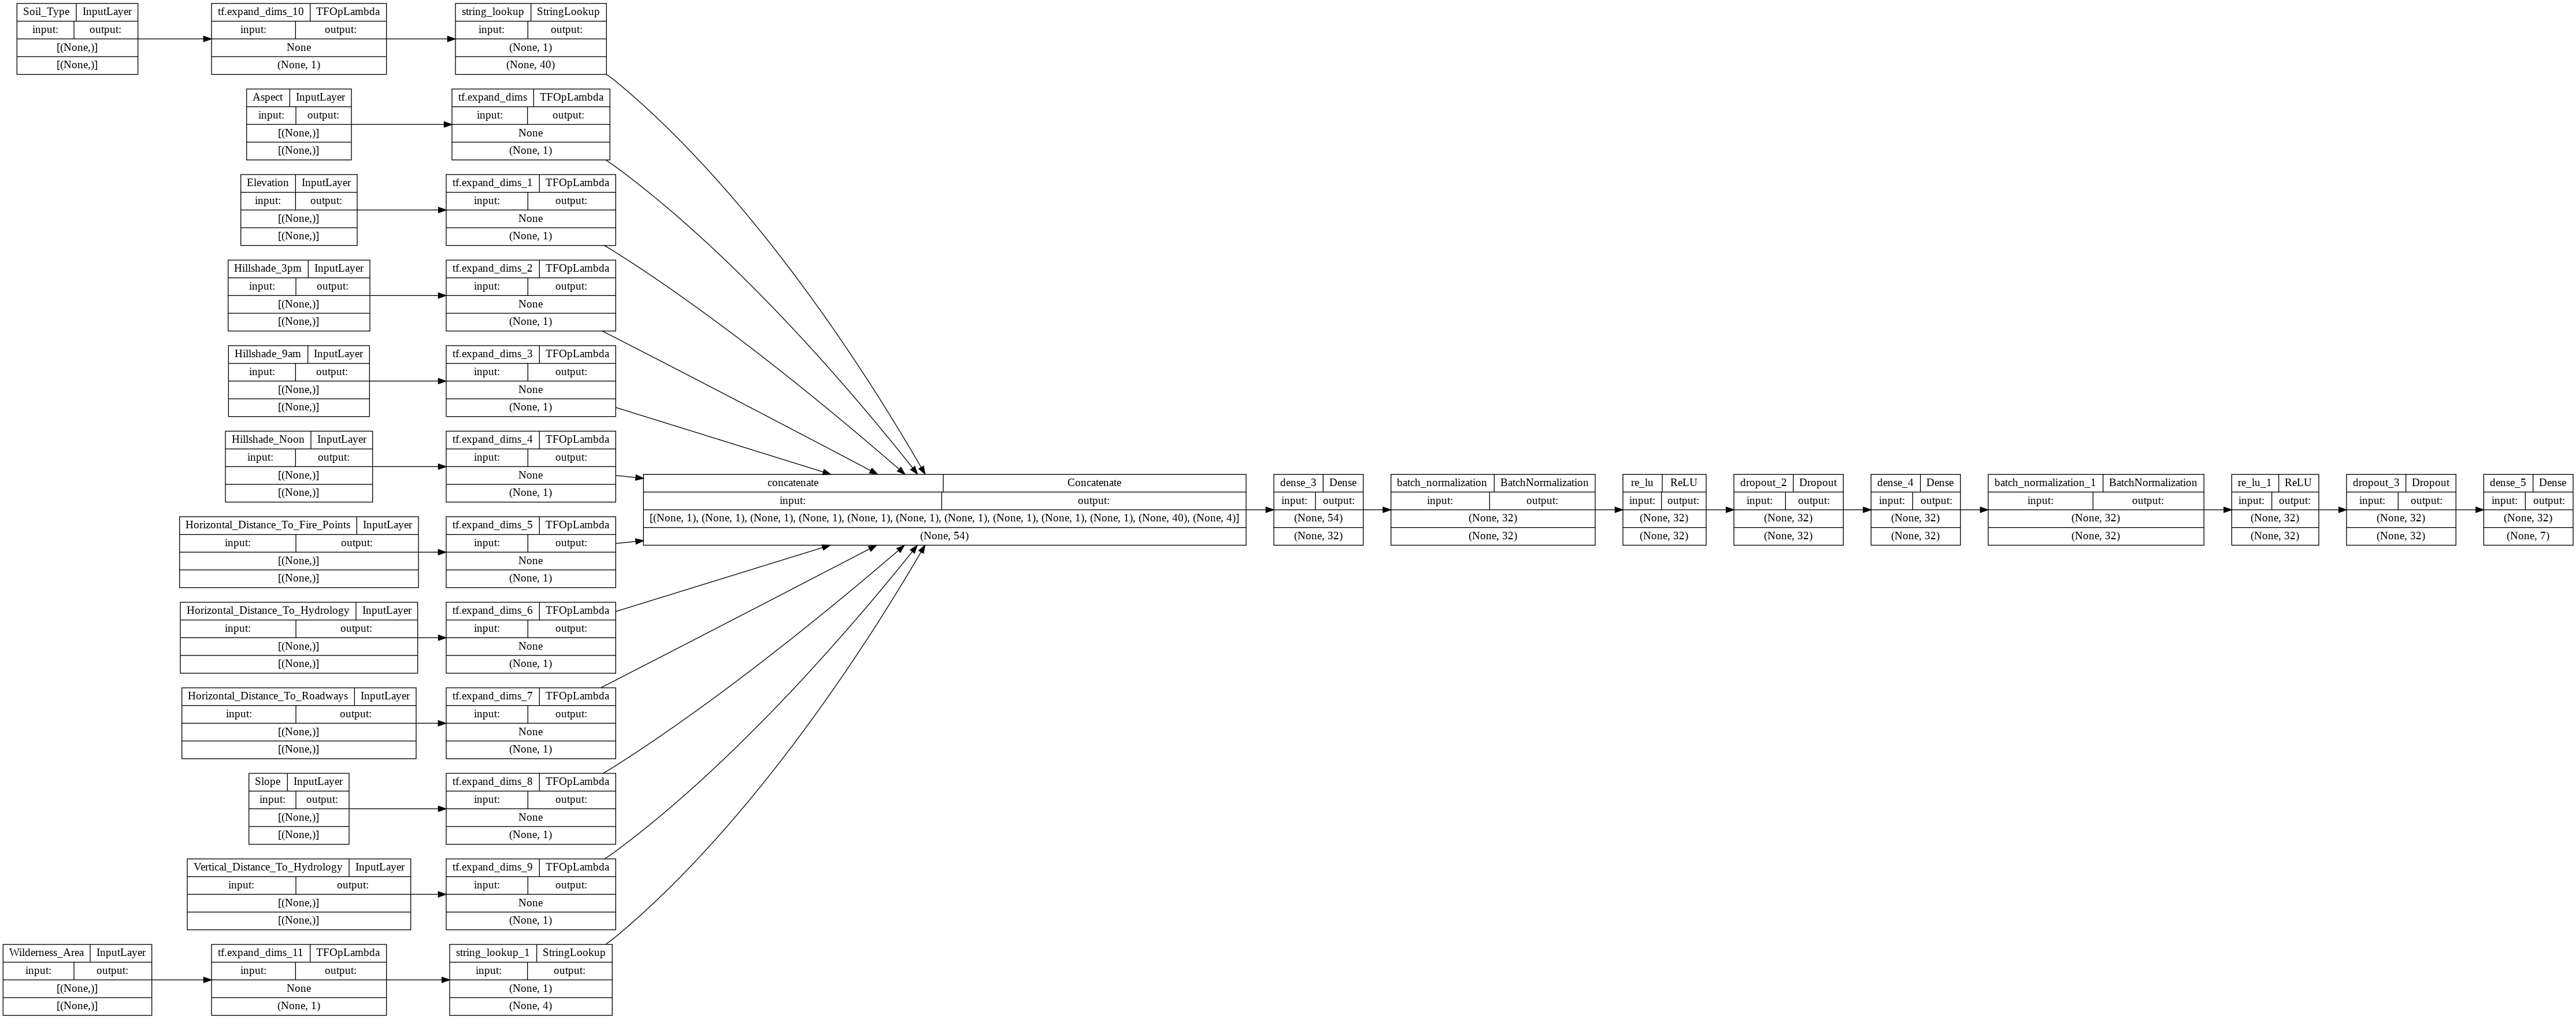

In [36]:
def create_baseline_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)

    for units in hidden_units:
        features = layers.Dense(units)(features)
        features = layers.BatchNormalization()(features)
        features = layers.ReLU()(features)
        features = layers.Dropout(dropout_rate)(features)

    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


baseline_model = create_baseline_model()
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")

In [37]:
run_experiment(baseline_model)

Start training the model...
Epoch 1/50
1866/1866 [==============================] - 19s 9ms/step - loss: 0.7764 - sparse_categorical_accuracy: 0.6760
Epoch 2/50
1866/1866 [==============================] - 10s 5ms/step - loss: 0.6636 - sparse_categorical_accuracy: 0.7134
Epoch 3/50
1866/1866 [==============================] - 9s 5ms/step - loss: 0.6348 - sparse_categorical_accuracy: 0.7251
Epoch 4/50
1866/1866 [==============================] - 9s 5ms/step - loss: 0.6157 - sparse_categorical_accuracy: 0.7336
Epoch 5/50
1866/1866 [==============================] - 9s 5ms/step - loss: 0.6059 - sparse_categorical_accuracy: 0.7378
Epoch 6/50
1866/1866 [==============================] - 9s 5ms/step - loss: 0.5981 - sparse_categorical_accuracy: 0.7424
Epoch 7/50
1866/1866 [==============================] - 9s 5ms/step - loss: 0.5907 - sparse_categorical_accuracy: 0.7453
Epoch 8/50
1866/1866 [==============================] - 9s 5ms/step - loss: 0.5853 - sparse_categorical_accuracy: 0.7486
Ep

### Model 2: Wide and Deep
Create a Wide & Deep model where the wide part of the model a linear model, while the
deep part of the model is a multi-layer feed-forward network. Use the sparse
representation of the input features in the wide part of the model and the dense
representation of the input features for the deep part of the model.

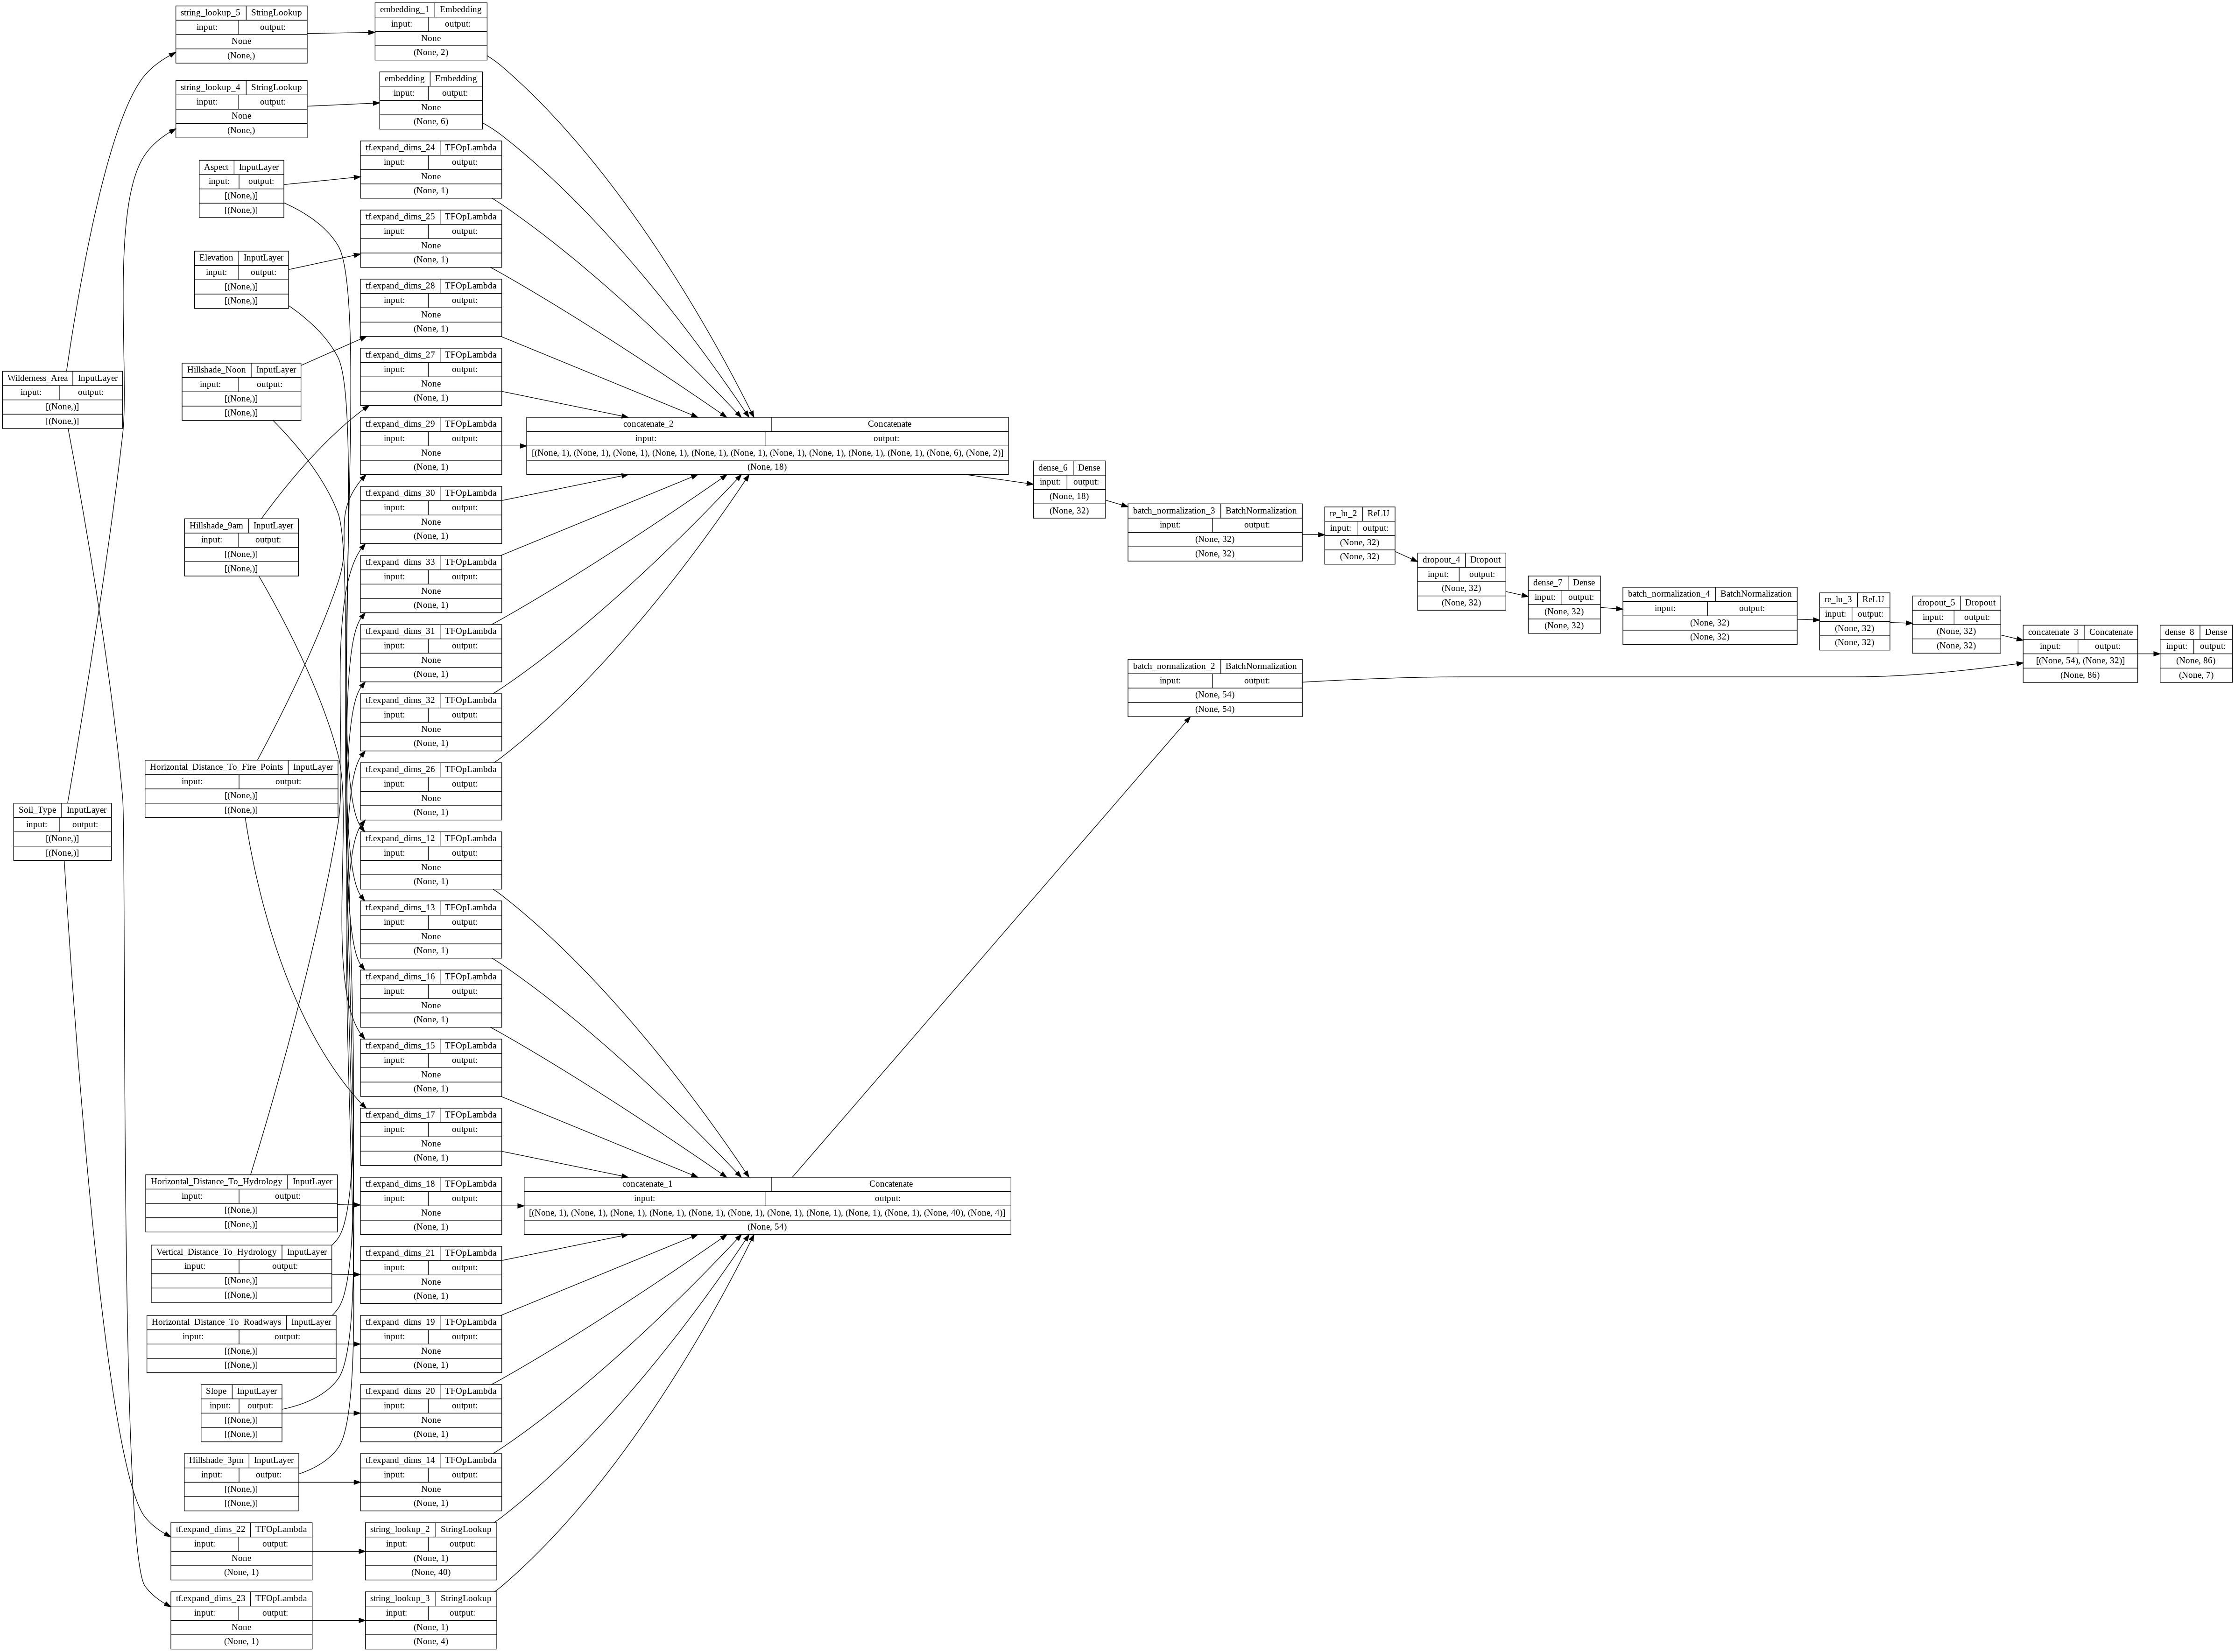

In [38]:
def create_wide_and_deep_model():

    inputs = create_model_inputs()
    wide = encode_inputs(inputs)
    wide = layers.BatchNormalization()(wide)

    deep = encode_inputs(inputs, use_embedding=True)
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([wide, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


wide_and_deep_model = create_wide_and_deep_model()
keras.utils.plot_model(wide_and_deep_model, show_shapes=True, rankdir="LR")

In [39]:
run_experiment(wide_and_deep_model)

Start training the model...
Epoch 1/50
1866/1866 [==============================] - 18s 9ms/step - loss: 0.6955 - sparse_categorical_accuracy: 0.7096
Epoch 2/50
1866/1866 [==============================] - 12s 6ms/step - loss: 0.6043 - sparse_categorical_accuracy: 0.7378
Epoch 3/50
1866/1866 [==============================] - 12s 6ms/step - loss: 0.5880 - sparse_categorical_accuracy: 0.7444
Epoch 4/50
1866/1866 [==============================] - 12s 6ms/step - loss: 0.5749 - sparse_categorical_accuracy: 0.7503
Epoch 5/50
1866/1866 [==============================] - 12s 6ms/step - loss: 0.5648 - sparse_categorical_accuracy: 0.7551
Epoch 6/50
1866/1866 [==============================] - 12s 6ms/step - loss: 0.5574 - sparse_categorical_accuracy: 0.7589
Epoch 7/50
1866/1866 [==============================] - 12s 6ms/step - loss: 0.5508 - sparse_categorical_accuracy: 0.7613
Epoch 8/50
1866/1866 [==============================] - 12s 6ms/step - loss: 0.5445 - sparse_categorical_accuracy: 0.7

### Model 3: Deep and Cross 
Create a Deep & Cross model. The deep part of this model is the same as the deep part
created in the previous experiment. The key idea of the cross part is to apply explicit
feature crossing in an efficient way, where the degree of cross features grows with layer
depth.

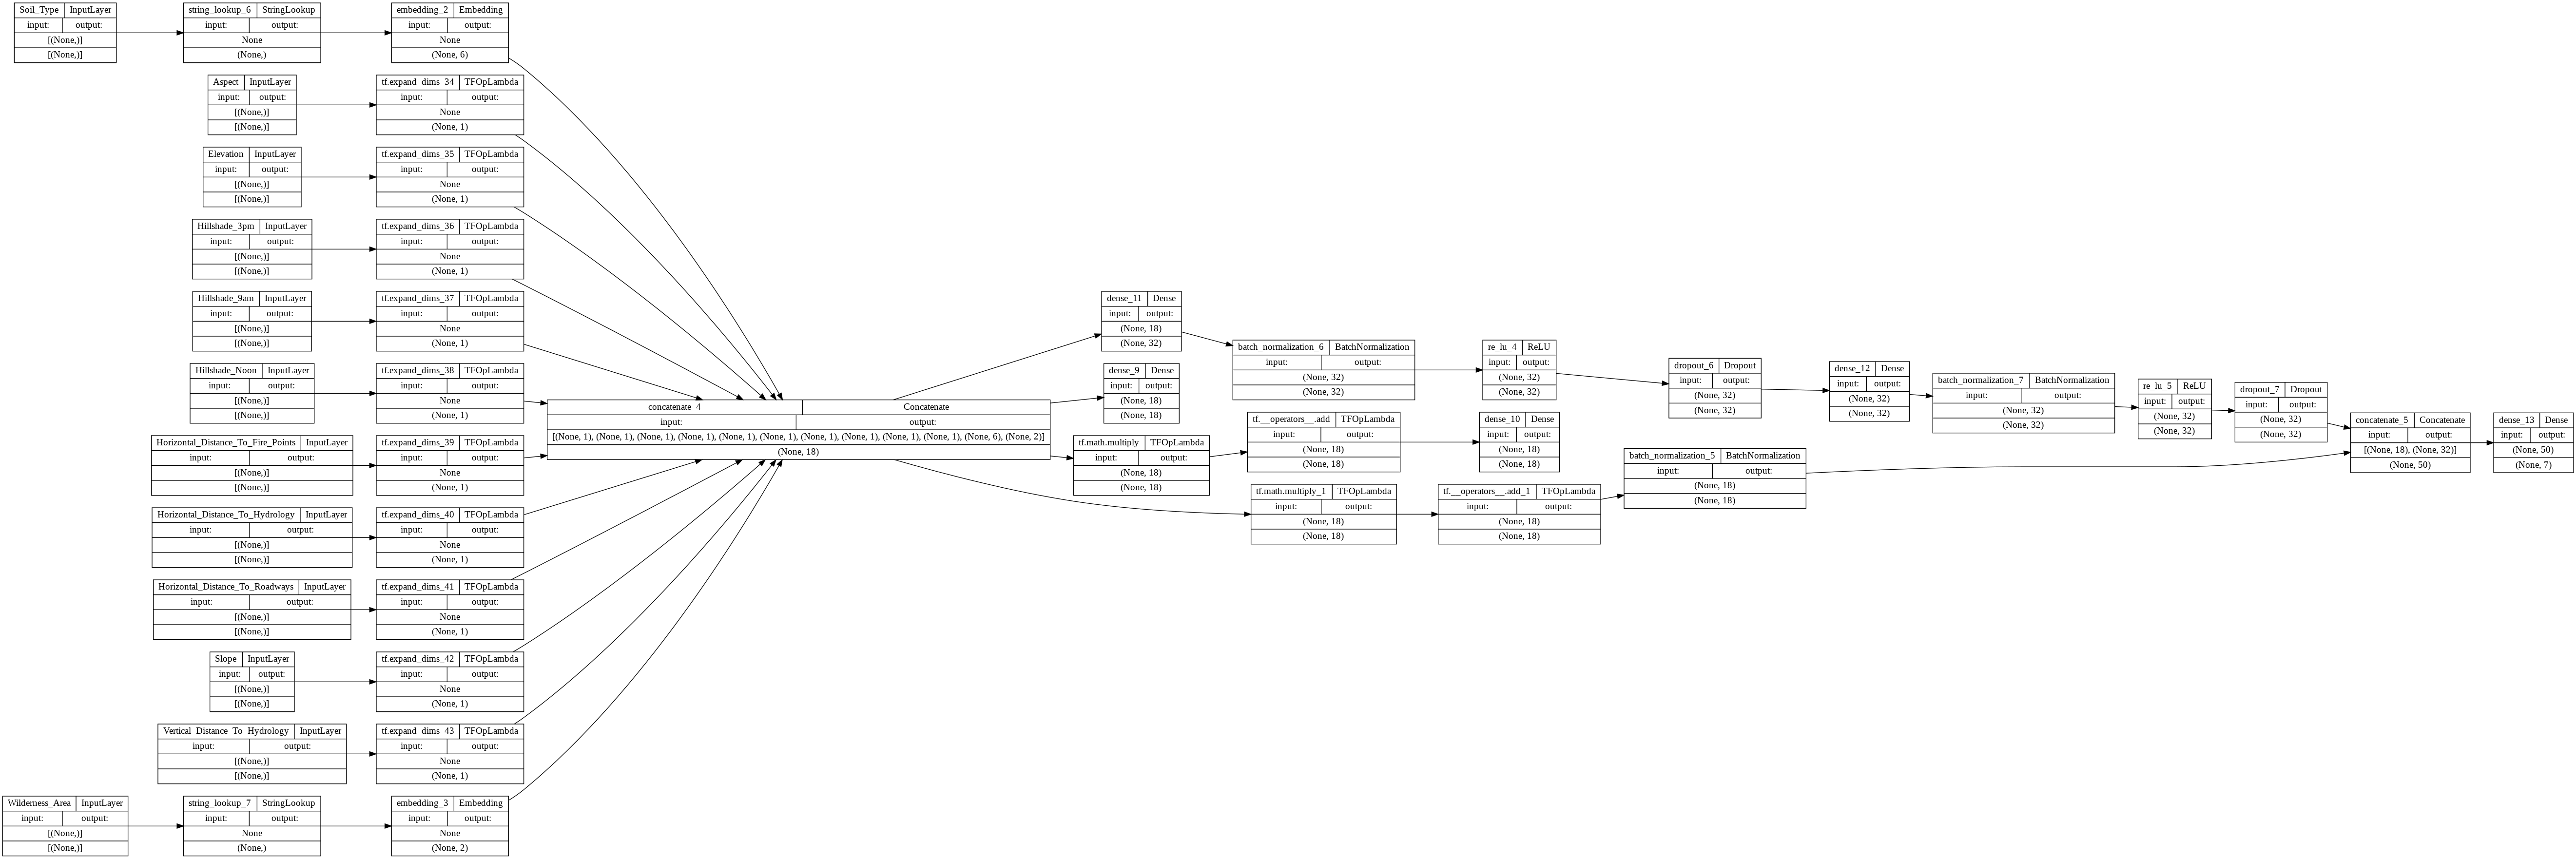

In [40]:
def create_deep_and_cross_model():

    inputs = create_model_inputs()
    x0 = encode_inputs(inputs, use_embedding=True)

    cross = x0
    for _ in hidden_units:
        units = cross.shape[-1]
        x = layers.Dense(units)(cross)
        cross = x0 * x + cross
    cross = layers.BatchNormalization()(cross)

    deep = x0
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([cross, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


deep_and_cross_model = create_deep_and_cross_model()
keras.utils.plot_model(deep_and_cross_model, show_shapes=True, rankdir="LR")

In [41]:
run_experiment(deep_and_cross_model)

Start training the model...
Epoch 1/50
1866/1866 [==============================] - 17s 8ms/step - loss: 0.6913 - sparse_categorical_accuracy: 0.7085
Epoch 2/50
1866/1866 [==============================] - 11s 6ms/step - loss: 0.5909 - sparse_categorical_accuracy: 0.7429
Epoch 3/50
1866/1866 [==============================] - 11s 6ms/step - loss: 0.5721 - sparse_categorical_accuracy: 0.7513
Epoch 4/50
1866/1866 [==============================] - 11s 6ms/step - loss: 0.5603 - sparse_categorical_accuracy: 0.7569
Epoch 5/50
1866/1866 [==============================] - 11s 6ms/step - loss: 0.5508 - sparse_categorical_accuracy: 0.7605
Epoch 6/50
1866/1866 [==============================] - 11s 6ms/step - loss: 0.5450 - sparse_categorical_accuracy: 0.7633
Epoch 7/50
1866/1866 [==============================] - 11s 6ms/step - loss: 0.5395 - sparse_categorical_accuracy: 0.7659
Epoch 8/50
1866/1866 [==============================] - 11s 6ms/step - loss: 0.5351 - sparse_categorical_accuracy: 0.7

#### The wide and deep, and cross and deep models show us a high accuracy of ~80% compared to the baseline model which shows us an accuracy of ~75%.
#### The wide and deep, and cross and deep models give us a loss of ~0.49 compared to the baseline model which gives us a loss of ~0.54.
-----

# Exercise 2

#### Importing the dataset

In [42]:
stock_train = pd.read_csv("Google_Stock_Price_Train.csv")
stock_train

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"


In [43]:
train_data = stock_train.iloc[:,1:2].values
train_data

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

In [44]:
# normalizing the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
train_data_scaled.shape

(1258, 1)

In [45]:
# splitting the data into X_train and y_train
X_train = []
Y_train = []
timesteps = 50

for i in range(timesteps, len(train_data_scaled)):
    X_train.append(train_data_scaled[i - timesteps:i, 0])
    Y_train.append(train_data_scaled[i,0])
    
X_train, Y_train = np.array(X_train), np.array(Y_train)

# reshaping the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

### SimpleRNN Model

In [53]:
simplernn = tf.keras.Sequential()
simplernn.add(tf.keras.layers.SimpleRNN(units=50, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1],1)))
simplernn.add(tf.keras.layers.SimpleRNN(units=50, activation='tanh', return_sequences=True))
simplernn.add(tf.keras.layers.SimpleRNN(units=50, activation='tanh', return_sequences=True))
simplernn.add(tf.keras.layers.SimpleRNN(units=50, activation='tanh'))
simplernn.add(tf.keras.layers.Dropout(0.2)) # adding a dropout layer
simplernn.add(tf.keras.layers.Dense(units=1)) # output layer
simplernn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_12 (SimpleRNN)   (None, 50, 50)            2600      
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 50, 50)            5050      
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, 50, 50)            5050      
                                                                 
 simple_rnn_15 (SimpleRNN)   (None, 50)                5050      
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 51        
                                                                 
Total params: 17,801
Trainable params: 17,801
Non-trai

In [54]:
# fitting the model
simplernn.compile(optimizer='adam', loss='mean_squared_error')
history_rnn = simplernn.fit(X_train, Y_train, epochs=50, batch_size=32, validation_split=0.15)

Epoch 1/50
33/33 [==============================] - 8s 180ms/step - loss: 0.3648 - val_loss: 0.0194
Epoch 2/50
33/33 [==============================] - 6s 172ms/step - loss: 0.1155 - val_loss: 0.0052
Epoch 3/50
33/33 [==============================] - 5s 167ms/step - loss: 0.1016 - val_loss: 0.0538
Epoch 4/50
33/33 [==============================] - 5s 163ms/step - loss: 0.0738 - val_loss: 0.0122
Epoch 5/50
33/33 [==============================] - 5s 159ms/step - loss: 0.0458 - val_loss: 0.0017
Epoch 6/50
33/33 [==============================] - 5s 162ms/step - loss: 0.0282 - val_loss: 7.2157e-04
Epoch 7/50
33/33 [==============================] - 5s 164ms/step - loss: 0.0248 - val_loss: 0.0042
Epoch 8/50
33/33 [==============================] - 5s 165ms/step - loss: 0.0163 - val_loss: 0.0095
Epoch 9/50
33/33 [==============================] - 5s 165ms/step - loss: 0.0099 - val_loss: 0.0032
Epoch 10/50
33/33 [==============================] - 5s 163ms/step - loss: 0.0071 - val_loss: 0.

In [55]:
test_data = pd.read_csv('Google_Stock_Price_Test.csv')
train = train_data[:len(train_data) - 50]
test = train_data[len(train):]

In [56]:
inputs = train_data[len(train_data) - len(test_data) - timesteps:]
inputs = scaler.transform(inputs)

In [57]:
# building test set of 50 timesteps
X_test = []
for i in range(timesteps, inputs.shape[0]):
    X_test.append(inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [58]:
# predicting using the values in the test set
predicted_data = simplernn.predict(X_test)
predicted_data = scaler.inverse_transform(predicted_data)

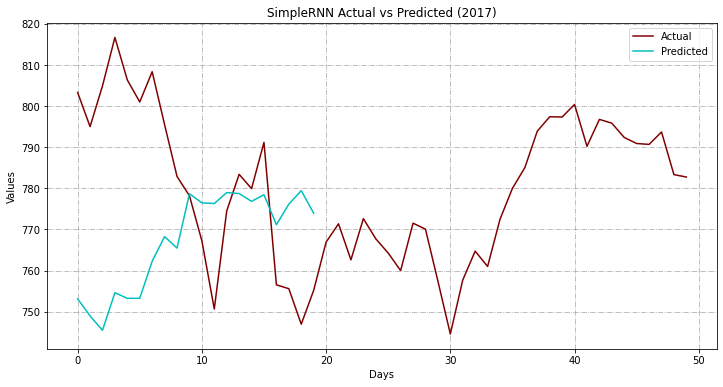

In [59]:
# plotting actual vs predicted values for 2017 (RNN)
plt.figure(figsize=(12,6))
plt.title("SimpleRNN Actual vs Predicted (2017)")
plt.plot(test, color="maroon", label="Actual")
plt.plot(predicted_data, color="c", label="Predicted")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.grid(linestyle='dashdot')
plt.show()

### LSTM Model

In [62]:
# building and fitting an LSTM model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(10, return_sequences=True, input_shape=(None, 1)))
model.add(tf.keras.layers.LSTM(10, return_sequences=True))
model.add(tf.keras.layers.LSTM(10, return_sequences=True))
model.add(tf.keras.layers.LSTM(10))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))
model.compile(loss="mean_squared_error", optimizer='Adam')
history_lstm = model.fit(X_train, Y_train, epochs=50, batch_size=1, validation_split=0.15)

Epoch 1/50
1026/1026 [==============================] - 18s 13ms/step - loss: 0.0190 - val_loss: 0.0100
Epoch 2/50
1026/1026 [==============================] - 13s 12ms/step - loss: 0.0067 - val_loss: 0.0039
Epoch 3/50
1026/1026 [==============================] - 13s 12ms/step - loss: 0.0056 - val_loss: 0.0025
Epoch 4/50
1026/1026 [==============================] - 12s 12ms/step - loss: 0.0044 - val_loss: 0.0101
Epoch 5/50
1026/1026 [==============================] - 13s 12ms/step - loss: 0.0037 - val_loss: 0.0012
Epoch 6/50
1026/1026 [==============================] - 13s 12ms/step - loss: 0.0036 - val_loss: 0.0073
Epoch 7/50
1026/1026 [==============================] - 13s 12ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 8/50
1026/1026 [==============================] - 13s 12ms/step - loss: 0.0031 - val_loss: 0.0091
Epoch 9/50
1026/1026 [==============================] - 13s 12ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 10/50
1026/1026 [==============================] - 13s 12m

In [63]:
# predicting using the values in the test set
predicted_data2 = model.predict(X_test)
predicted_data2 = scaler.inverse_transform(predicted_data2)

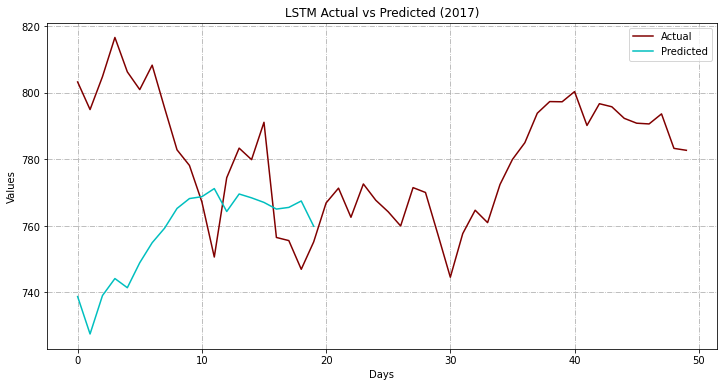

In [64]:
# plotting
plt.figure(figsize=(12,6))
plt.title("LSTM Actual vs Predicted (2017)")
plt.plot(test, color="maroon", label="Actual")
plt.plot(predicted_data2, color="c", label="Predicted")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.grid(linestyle='dashdot')
plt.show()